In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, optimizers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters

%matplotlib inline

register_matplotlib_converters()
sns.set(style="darkgrid", font_scale=1.5)

LENGTH = 20
LOOK_AHEAD_LENGTH = 3

# Train Model

In [2]:
def preprocessTestingData(data, length, look_ahead_length):
    hist = []
    target = []

    for i in range(len(data)-length-look_ahead_length):
        x = data[i:i+length]
        y = data[i+length+look_ahead_length]
        hist.append(x)
        target.append(y)
    
    # Convert into numpy arrays and shape correctly (len(dataset), length) and (len(dataset), 1) respectivly
    hist = np.array(hist)
    target = np.array(target)
    target = target.reshape(-1,1)

    #Reshape the input into (len(dataset), length, 1)
    hist = hist.reshape((len(hist), length, 1))

    return(hist, target)

In [3]:
def trainModel(datasets, length, model=None, quiet=False):
    for dataset in datasets:
        X_train, y_train = preprocessTestingData(dataset, length, LOOK_AHEAD_LENGTH)

        if not model:
            # Create model and compile
            model = tf.keras.Sequential()
            model.add(layers.LSTM(units=32, return_sequences=True, input_shape=(length,1), dropout=0.2))
            model.add(layers.LSTM(units=32, return_sequences=True, dropout=0.2))
            model.add(layers.LSTM(units=32, dropout=0.2))
            model.add(layers.Dense(units=1))
            model.compile(optimizer='adam', loss='mean_squared_error')

        # Perform training
        output = 1
        if quiet:
            output = 0
        history = model.fit(X_train, y_train, epochs=60, batch_size=32, verbose=output)

        # Show loss
        if not quiet:
            loss = history.history['loss']
            epoch_count = range(1, len(loss) + 1)
            plt.figure(figsize=(6,4))
            plt.plot(epoch_count, loss, 'r--')
            plt.legend(['Training Loss'])
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.show()

    return model

In [4]:
def scaleData(paths):
    scaler = MinMaxScaler()
    datasets = []
    for path in paths:
        # perform partial fits on all datasets
        datasets.append(pd.read_csv(path)[['price']])
        scaler = scaler.partial_fit(datasets[-1])
    for i in range(len(datasets)):
        # once all partial fits have been performed, transform every file
        datasets[i] = scaler.transform(datasets[i])
    return (datasets, scaler)


Epoch 1/60
292/292 [==============================] - 6s 11ms/step - loss: 0.0303
Epoch 2/60
292/292 [==============================] - 3s 10ms/step - loss: 0.0046
Epoch 3/60
292/292 [==============================] - 3s 10ms/step - loss: 0.0041
Epoch 4/60
292/292 [==============================] - 3s 10ms/step - loss: 0.0028
Epoch 5/60
292/292 [==============================] - 3s 10ms/step - loss: 0.0021
Epoch 6/60
292/292 [==============================] - 3s 10ms/step - loss: 0.0018
Epoch 7/60
292/292 [==============================] - 3s 10ms/step - loss: 0.0018
Epoch 8/60
292/292 [==============================] - 3s 10ms/step - loss: 0.0018
Epoch 9/60
292/292 [==============================] - 3s 10ms/step - loss: 0.0019
Epoch 10/60
292/292 [==============================] - 3s 10ms/step - loss: 0.0017
Epoch 11/60
292/292 [==============================] - 3s 10ms/step - loss: 0.0016
Epoch 12/60
292/292 [==============================] - 3s 10ms/step - loss: 0.0017
Epoch 13/60
2

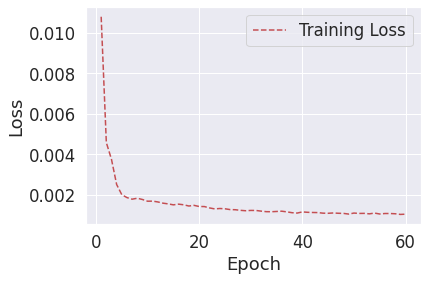

In [5]:
paths = ["../data/dump.csv"]

datasets, scaler = scaleData(paths)

model = trainModel(datasets, LENGTH)

# Test Model
## Evaluation Helpers

In [6]:
def sub_sample(arr1, arr2):
    return (arr1, arr2)

def evaluate_model(real_data, predicted_data, inherent_loss):
    real_data = real_data.reshape(len(real_data))
    predicted_data = predicted_data.reshape(len(predicted_data))

    real_diff = np.diff(real_data)
    predicted_diff = np.diff(predicted_data)

    correct_slopes = 0
    profit = 0
    for i in range(len(real_data)-1-LOOK_AHEAD_LENGTH):
        if np.sign(real_diff[i+LOOK_AHEAD_LENGTH-1]) == np.sign(predicted_diff[i]):
            correct_slopes = correct_slopes + 1
            
            # If we have a positive slope calculate profit
            if predicted_diff[i] > 1.75:
                # we subtract inherent_loss due to the limit market mechanics
                revenue = (real_data[i+1] - real_data[i]) - inherent_loss
                if revenue > 0:
                    # print(f"Found a profit where current value is {real_data[i+1]} last was {real_data[i]} net {revenue}")
                    profit = profit + revenue

        else:
            # We guessed wrong
            if predicted_diff[i] > 0:
                # we would have bought
                revenue = (real_data[i+1] - real_data[i]) - inherent_loss
                # print(f"Selling at a loss of {revenue}")
                profit = profit + revenue

    return (correct_slopes, profit)


In [7]:
def eval_model_on_dataset(actual, prediction, inherent_loss):
    # Subsample the test points, this seems to increase accuracy
    real_subbed, pred_subbed = sub_sample(actual, prediction)

    # Determine the number of cases in which we predicted a correct increase
    correct_slopes, profit = evaluate_model(real_subbed, pred_subbed, inherent_loss)

    print(f"Found {correct_slopes} out of {len(real_subbed)-1}")
    precent_success = (correct_slopes/(len(real_subbed)-1)) * 100
    print(f"{precent_success}%")
    print("Profit:", profit)
    return profit

## Test Model

In [8]:
def testModel(model, path_to_testing_dataset, quiet=False):

    datasets, scaler = scaleData([path_to_testing_dataset])

    hist, actual = preprocessTestingData(datasets[0], LENGTH, LOOK_AHEAD_LENGTH)

    pred = model.predict(hist)

    pred_transformed = scaler.inverse_transform(pred)
    actual_transformed = scaler.inverse_transform(actual)

    if not quiet:
        plt.figure(figsize=(12,8))
        plt.plot(actual_transformed, color='blue', label='Real')
        plt.plot(pred_transformed, color='red', label='Prediction')
        plt.title('ETH Price Prediction')
        plt.legend()
        plt.show()

    return eval_model_on_dataset(actual=actual_transformed, prediction=pred_transformed, inherent_loss=1.5)


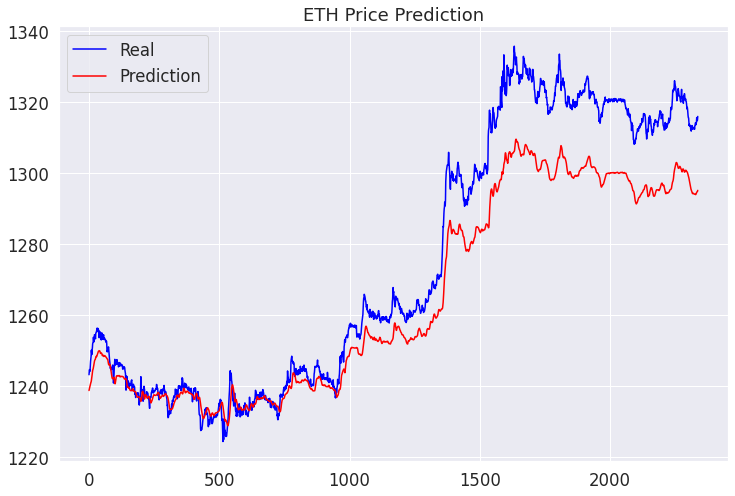

Found 1168 out of 2336
50.0%
Profit: -917.3212839999967


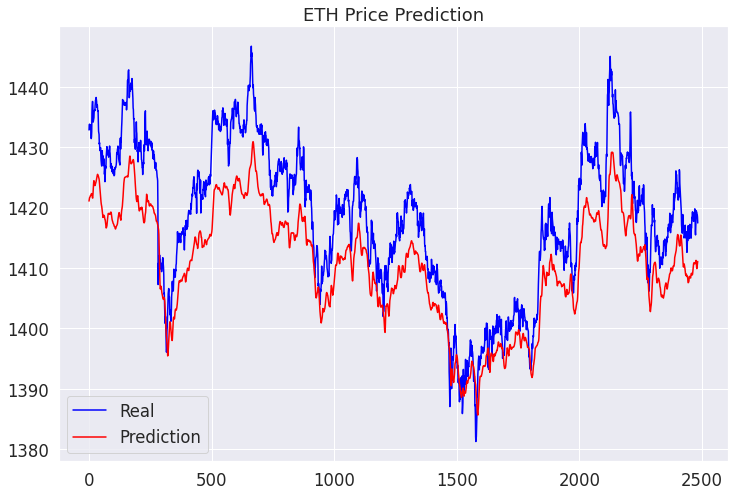

Found 1308 out of 2483
52.67821184051551%
Profit: -822.6900570000012


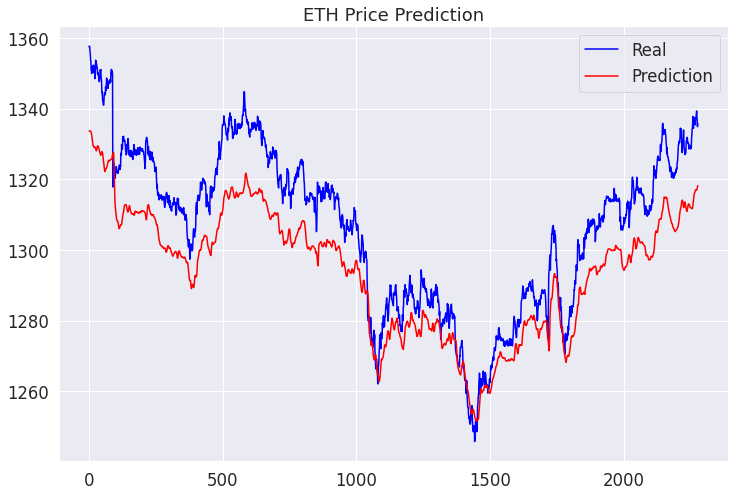

Found 1107 out of 2276
48.63796133567663%
Profit: -933.9704239999983


-933.9704239999983

In [9]:
testModel(model, "../data/test_data/test6.csv")
testModel(model, "../data/test_data/test8.csv")
testModel(model, "../data/test_data/test10.csv")

# Single Prediction

In [35]:
# For example, if we just want to predict the next timestep in the dataset we can prepare it as such:

# 1. get the [length] last points from the data set since that's what we care about
length = LENGTH
most_recent_period = pd.read_csv('../data/MorningTest2.csv')[['price']].tail(length)

# 2. convert to numpy array 
most_recent_period = np.array(most_recent_period)

# 3. normalize data
scaler = MinMaxScaler()
most_recent_period_scaled = scaler.fit_transform(most_recent_period)

# 4. reshape to the 3D tensor we expected (1, length, 1)
most_recent_period_scaled_shaped = most_recent_period_scaled.reshape((1, length, 1))

# 5. Predict
prediction = model.predict(most_recent_period_scaled_shaped)

# 6. Un-normalize the data
result = scaler.inverse_transform(prediction)

print(f"${result[0][0]}")

$1140.007568359375


# Prediction Success Evaluation

In [36]:
model.save("my_model")

INFO:tensorflow:Assets written to: my_model/assets
INFO:tensorflow:Assets written to: my_model/assets


In [37]:
pink = models.load_model("my_model")

In [38]:
profits = []
for length in np.arange(5, 360, 5):
    for sub in np.arange(10, 480, 5):
        try:
            LENGTH = length
            SUBSAMPLING = sub
            model = trainModel(datasets, LENGTH, quiet=True)
            profit = testModel(model, "../data/MorningTest.csv", quiet=True)
            profits.append((profit, length, sub))
            print(sorted(profits, key=lambda tup: -tup[0])[0:20])
        except:
            pass


Found 19147 out of 36991
51.761239220350895%
Profit: -13421.226563999982
[(-13421.226563999982, 5, 10)]


In [ ]:
print("FINAL RESULTS")
sorted(profits, key=lambda tup: tup[0])[0:20]
